In [1]:
from bertopic import BERTopic
from sklearn.datasets import fetch_20newsgroups
import torch
from torch.utils.data import Dataset,DataLoader
import pandas as pd
import numpy as np

In [2]:
dataset = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))
data = dataset["data"]
label = dataset["target"]
label_names = dataset["target_names"]

In [3]:
class News20Dataset(Dataset):
    def __init__(self,tokenizer=None,max_length=256,transforms=None):
        self.raw_dataset = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))
        self.data = self.raw_dataset["data"]
        self.label = self.raw_dataset["target"]
        self.label_name = self.raw_dataset["target_names"]
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        text = self.data[idx]
        encode_text = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors="pt")
        return encode_text,text,self.label[idx]

In [4]:
# embeddings0 = np.load('embeddings/distilbert-base-cased_last_mean.npy')
# embeddings1 = np.load('embeddings/distilbert-base-cased_last_mean.npy')
# print(embeddings0.shape,embeddings1.shape)
# embeddings =np.concatenate([embeddings0,embeddings1],axis=1)
embeddings = np.load('embeddings/jina-embeddings-v2-small-en.npy')

## NER Statistics Embedding

In [32]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

ner_tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
ner_model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")

ner_pipeLine = pipeline("ner", model=ner_model, tokenizer=ner_tokenizer,device="cuda")
example = "My name is Wolfgang and I live in Berlin"

ner_results = ner_pipeLine(example)
print(ner_results)


Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[{'entity': 'B-PER', 'score': 0.9990139, 'index': 4, 'word': 'Wolfgang', 'start': 11, 'end': 19}, {'entity': 'B-LOC', 'score': 0.999645, 'index': 9, 'word': 'Berlin', 'start': 34, 'end': 40}]


In [53]:
import re
def count_words(text):
    text = re.sub(r'[.,\n]', ' ', text)
    words = [word for word in text.split(" ") if word]
    word_count = len(words)
    return word_count

def ner_parser(raw_results):
    final_results = []
    for item in raw_results:
        statistic_result=[0,0] # 0:Person,1:Loctaion
        for entity_result in item:
            if entity_result["entity"] == "B-PER":
                statistic_result[0]+=1
                continue
            if entity_result["entity"] == "B-LOC":
                statistic_result[1]+=1
                continue
        final_results.append(statistic_result)
    return final_results

In [51]:
ner_parser([ner_results])

[[1, 1]]

In [39]:
raw_dataset = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))
data = raw_dataset["data"]
batch_size = 512
ner_all = []
for i in range(0,len(data),batch_size):
    ner_batch = ner_pipeLine(data[i:i+batch_size])
    result_batch = ner_parser(ner_batch)
    ner_all.extend(result_batch)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [66]:
ner_all_norm = []
for idx,item in enumerate(data):
    words_num = count_words(item)
    if words_num == 0:
       ner_all_norm.append([0,0])
       continue
    ner_all_norm.append([ner_all[idx][0]/words_num,ner_all[idx][1]/words_num])

In [67]:
ner_embeddings = np.array(ner_all_norm)

In [ ]:
embeddings =np.concatenate([embeddings,ner_embeddings],axis=1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


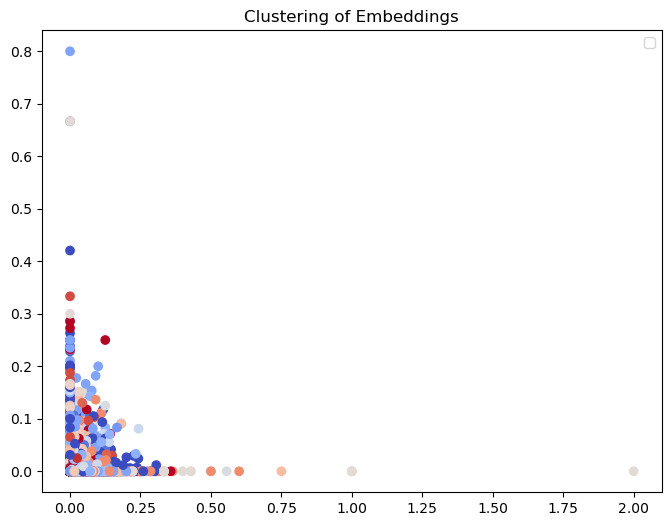

In [68]:
plt.figure(figsize=(8, 6))
unique_labels = np.unique(pred_labels)
plt.scatter(ner_embeddings[:, 0], ner_embeddings[:, 1],c=pred_labels,cmap='coolwarm')
plt.title('Clustering of Embeddings')
plt.legend()
plt.show()
# evaluate_ari(label,pred_labels)
# evaluate_nmi(label,pred_labels)
# evaluate_silhouette(embeddings,pred_labels)

## Reduce Dimension

In [5]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import umap
from utils.evalUtils import *


In [6]:
tsne = TSNE(n_components=2, perplexity=5, learning_rate=500, n_iter=3000, early_exaggeration=15, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)
# pca = PCA(n_components=2)
# embeddings_2d = pca.fit_transform(embeddings)

## Baseline-Kmeans

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


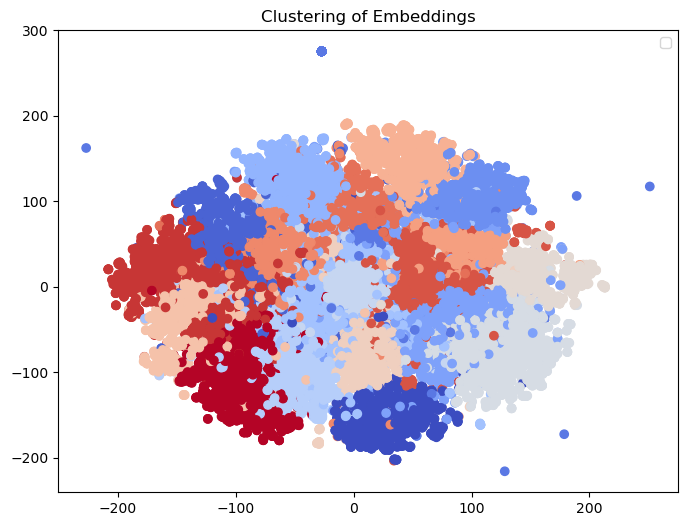

In [7]:
# dbscan = DBSCAN(eps=1, min_samples=5, metric='euclidean')
# pred_labels = dbscan.fit_predict(embeddings)

# reduce dimension 
reducer = umap.UMAP(n_components=16, random_state=42)
embeddings_reduced = reducer.fit_transform(embeddings)
# cluster
kmeans = KMeans(n_clusters=20, random_state=30)
kmeans.fit(embeddings_reduced)
pred_labels = kmeans.predict(embeddings_reduced)
# visualization
plt.figure(figsize=(8, 6))
unique_labels = np.unique(pred_labels)
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],c=pred_labels,cmap='coolwarm')
plt.title('Clustering of Embeddings')
plt.legend()
plt.savefig("figures/jina-embeddings-v2-small-en_kmeans_predict.png", dpi=300, bbox_inches='tight')
plt.show()

In [9]:
evaluate_ari(label,pred_labels)
evaluate_nmi(label,pred_labels)
evaluate_silhouette(embeddings,pred_labels)

Adjusted Rand Index (ARI): 0.2688
Normalized Mutual Information (NMI): 0.4329
Silhouette Score: 0.0716


0.07160214

## Proposed-Louvain Cluster

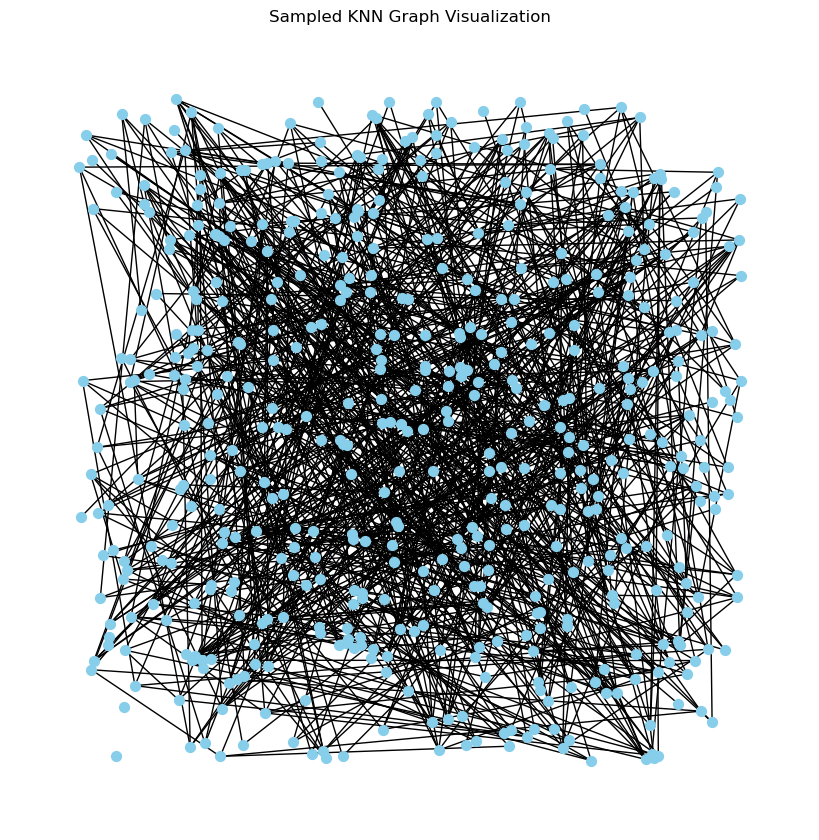

In [8]:
from sklearn.neighbors import NearestNeighbors
import networkx as nx
import random


reducer = umap.UMAP(n_components=128, random_state=42)
embeddings_reduced = reducer.fit_transform(embeddings)
knn = NearestNeighbors(n_neighbors=100)
knn.fit(embeddings_reduced)


adj_matrix = knn.kneighbors_graph(embeddings_reduced).toarray()
adj_matrix = adj_matrix-np.eye(adj_matrix.shape[0])
G = nx.from_numpy_array(adj_matrix)

nodes_list = list(G.nodes())
nodes_sampled = random.sample(nodes_list, 500)

G_sampled = G.subgraph(nodes_sampled)

plt.figure(figsize=(8, 8))
pos = nx.random_layout(G_sampled) 

nx.draw(G_sampled, pos, node_color='skyblue', node_size=50, with_labels=False)
plt.title("Sampled KNN Graph Visualization")
plt.show()


In [9]:
from sklearn.cluster import SpectralClustering
import community as community_louvain

partition = community_louvain.best_partition(G)
pred_labels = list(partition.values())
pred_labels=np.array(pred_labels)


# plt.figure(figsize=(8, 8))
# nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=300)
# nx.draw_networkx_edges(G, pos, alpha=0.5)
# plt.title("Spectral Graph Clustering")
# plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


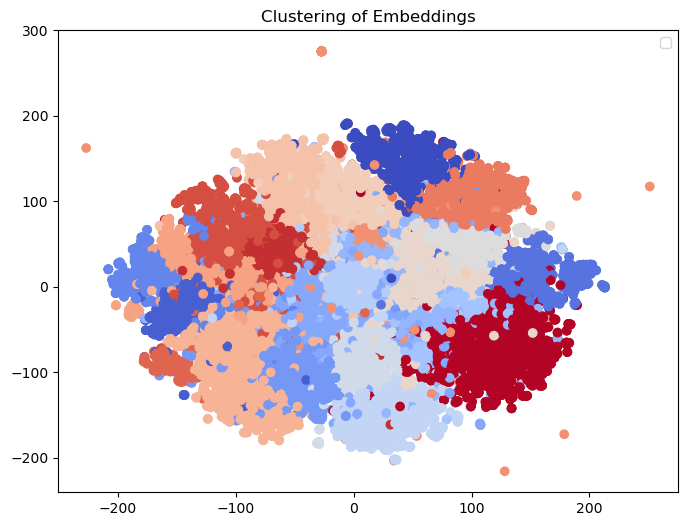

Adjusted Rand Index (ARI): 0.4269
Normalized Mutual Information (NMI): 0.5627
Silhouette Score: 0.0264


0.026377149

In [10]:
# reduce dimension 

# dbscan = DBSCAN(eps=1, min_samples=5, metric='euclidean')
# pred_labels = dbscan.fit_predict(embeddings)
plt.figure(figsize=(8, 6))
unique_labels = np.unique(pred_labels)
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],c=pred_labels,cmap='coolwarm')
plt.title('Clustering of Embeddings')
plt.savefig("figures/jina-embeddings-v2-small-en_louvain_predict.png", dpi=300, bbox_inches='tight')
plt.legend()
plt.show()
evaluate_ari(label,pred_labels)
evaluate_nmi(label,pred_labels)
evaluate_silhouette(embeddings,pred_labels)

## Proposed-Girvan-Newman

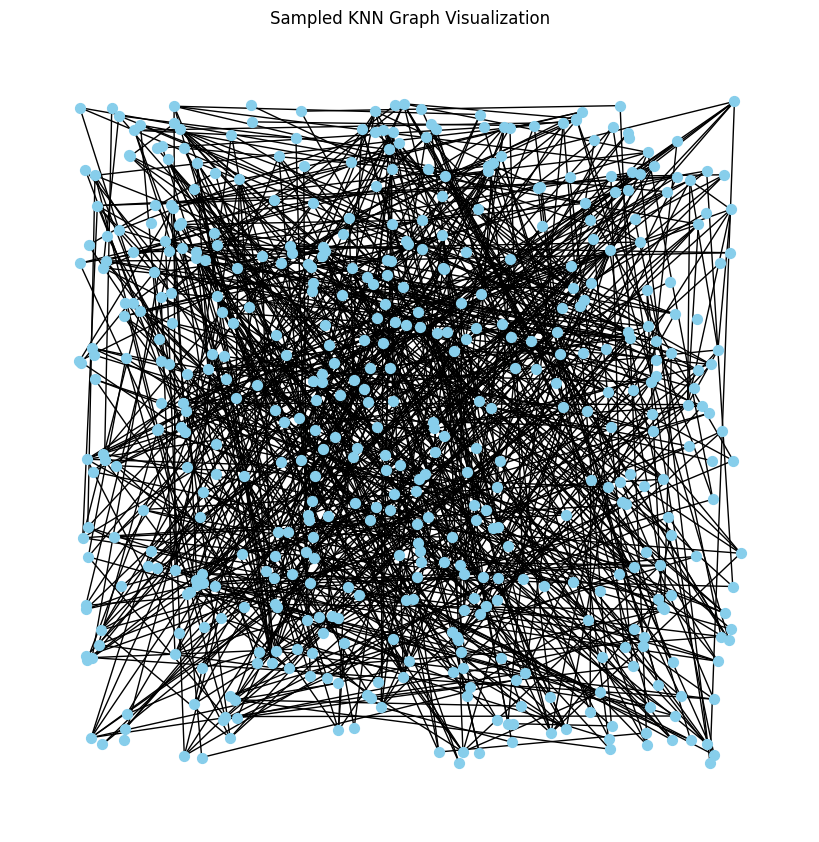

In [7]:
from sklearn.neighbors import NearestNeighbors
import networkx as nx
import random


reducer = umap.UMAP(n_components=256, random_state=42)
embeddings_reduced = reducer.fit_transform(embeddings)
knn = NearestNeighbors(n_neighbors=100)
knn.fit(embeddings_reduced)


adj_matrix = knn.kneighbors_graph(embeddings_reduced).toarray()
adj_matrix = adj_matrix-np.eye(adj_matrix.shape[0])
G = nx.from_numpy_array(adj_matrix)

nodes_list = list(G.nodes())
nodes_sampled = random.sample(nodes_list, 500)

G_sampled = G.subgraph(nodes_sampled)

plt.figure(figsize=(8, 8))
pos = nx.random_layout(G_sampled) 

nx.draw(G_sampled, pos, node_color='skyblue', node_size=50, with_labels=False)
plt.title("Sampled KNN Graph Visualization")
plt.show()


In [ ]:
from networkx.algorithms.community import girvan_newman
communities_generator = girvan_newman(G)

desired_communities = 20
current_communities = next(communities_generator)

for communities in communities_generator:
    current_communities = communities
    if len(current_communities) == desired_communities:
        break
for i, community in enumerate(current_communities):
    print(f"Community {i+1}: {sorted(community)}")